# Face Recognition using CNN

## Step 1:

At the first, you should load the required libraries:

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler
import pandas
from collections import Counter
from random import shuffle
import matplotlib.pyplot as plt

Import the Early Stopping Class

In [10]:
# import EarlyStopping
from pytorchtools import EarlyStopping

* __Set default values for my parameters__

In [11]:
batch_size = 64
validation_split = 0.2
num_folds= 2
num_epoch = 15
train_folder = './train_images'
test_folder = './test_images'
model_name = 'model'
model_folder = './models'
refresh_model = 30
patience = 4

* __Set inputs__

In [10]:
batch_size = int(input("Batch size: "))

Batch size: 64


In [6]:
validation_split = float(input("Percentage of the validation set (from 0 to 1): "))

Percentage of the validation set (from 0 to 1): 0.3


In [12]:
num_fold = int(input("Number of folds. If there is more folds than network type, folds network type will loop: "))

Number of folds. If there is more folds than network type, folds network type will loop: 2


In [13]:
num_epoch = int(input("Number of epoch: "))

Number of epoch: 15


In [14]:
train_folder = input("Train folder: ")

Train folder: ./train_images


In [15]:
test_folder = input("Test folder: ")

Test folder: ./test_images


In [ ]:
model_name = input("Model name: ")

In [ ]:
model_folder = input("Model folder: ")

In [37]:
refresh_model = int(input("Validating model rate: "))

Validating model rate: 50


In [52]:
patience = int(input("Patience for EarlyStopping: "))

Patience for EarlyStopping: 7


## Step 2:

* __Load labeled dataset and split it into a train data set and a validation dataset :__

In [12]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform)

dataset_size = len(trainset)
fold_size = int(dataset_size / num_folds)
fold_split_size = int(np.floor(validation_split * fold_size))
indices = list(range(dataset_size))

best_model = []
train_loader = []
validation_loader = []
shuffle(indices)

for i in range(num_folds):

    split_start = dataset_size - (fold_split_size * (i + 1))
    split_end = split_start + fold_split_size
    train_indices = indices[0:split_start - 1] + indices[split_end + 1:dataset_size]
    val_indices = indices[split_start:split_end]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    train_loader.append(torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                    sampler=train_sampler, num_workers=2))
    validation_loader.append(torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                         sampler=valid_sampler,num_workers=2))

* __Load unlabeled dataset and creating loaders:__

In [13]:
testset = torchvision.datasets.ImageFolder(root='./test_images',  transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('other', 'face')


* __Visualizing some random training images :__

In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
# get some random training images
dataiter = iter(train_loader[0])
images, labels = dataiter.next()

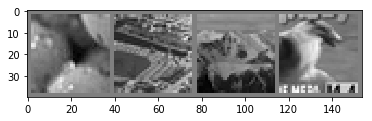

other other other other


In [8]:
# show images
imshow(torchvision.utils.make_grid([images[j] for j in range(4)]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

* __Some stats about the train dataset:__

In [9]:
def stat_img (train_loader):
    list_labels=[]
    for trainloader in train_loader:
        l = []
        for i, data in enumerate(trainloader,0):
            inputs, labels = data
            for j in range(len(labels)):
                l.append(classes[labels[j]])
            print(len(l))
        list_labels.append(l)
    
    return list_labels

In [ ]:
labels = stat_img (train_loader)

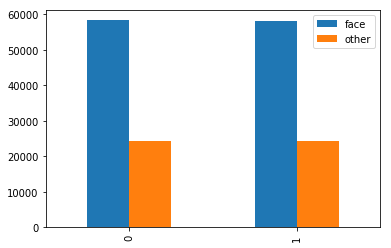

In [11]:
test = dict()
for i in range(len(labels)):
    test[i] = Counter(labels[i])
df = pandas.DataFrame.from_dict(test, orient='index')
df.plot(kind='bar')

In [12]:
print("******************************************")
print("******* Description of the datasets ****** ")
print("******************************************")

for i in range(len(labels)):
    faces = df['face'][i]
    others = df['other'][i]
    print("*************** DATASET N° {0:1} ************* ".format(i))
    print("------------------------------------------")
    print(" Number of faces : ",faces)
    print(" Number of others: ",others)
    print(" Total           : ", faces+others)
    print("------------------------------------------")
    print(" Number of faces :  {0:.0%}".format(faces/(faces+others)))
    print(" Number of others:  {0:.0%}".format(others/(faces+others)))
    print("******************************************")


******************************************
******* Description of the datasets ****** 
******************************************
*************** DATASET N° 0 ************* 
------------------------------------------
 Number of faces :  58331
 Number of others:  24216
 Total           :  82547
------------------------------------------
 Number of faces :  71%
 Number of others:  29%
******************************************
*************** DATASET N° 1 ************* 
------------------------------------------
 Number of faces :  58221
 Number of others:  24325
 Total           :  82546
------------------------------------------
 Number of faces :  71%
 Number of others:  29%
******************************************


## Step 3:

* __Defining the architecture of the Neural Network__

        1. First Architecture

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, 1)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [15]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


        2. Second Architecture

In [15]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 10, 5)
        self.fc1 = nn.Linear(10 * 6 * 6, 242)
        self.fc2 = nn.Linear(242, 42)
        self.fc3 = nn.Linear(42, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, 1)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [16]:
net2 = Net2()
print(net2)

Net2(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=360, out_features=242, bias=True)
  (fc2): Linear(in_features=242, out_features=42, bias=True)
  (fc3): Linear(in_features=42, out_features=2, bias=True)
)


* __Training with the first architecture__

In [20]:
def train_model(model,best_model):
    
    average_train = []
    average_valid = []

    for i in range(num_folds):
        
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=patience, verbose=True)
        
        best_loss = float('inf')
        
        # to track the training loss as the model trains
        train_losses = []
        # to track the validation loss as the model trains
        valid_losses = []
        # to track the average training loss per epoch as the model trains
        avg_train_losses = []
        # to track the average validation loss per epoch as the model trains
        avg_valid_losses = [] 
        
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model[i].parameters(), lr=0.001, momentum=0.9)
        
        print('Training fold %d' % i)  
        
        for epoch in range(1,num_epoch+1):
            ###################
            # train the model #
            ###################
            model[i].train() # prep model for training
            
            for batch, (data, target) in enumerate(train_loader[i], 1):

                # clear the gradients of all optimized variables
                optimizer.zero_grad()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model[i](data)
                
                target = torch.eye(2)[target.long()]
                # calculate the loss
                loss = criterion(output, target)
                # backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # perform a single optimization step (parameter update)
                optimizer.step()
                # record training loss
                train_losses.append(loss.item())

                if batch % refresh_model == 1:

                    ######################    
                    # validate the model #
                    ######################
                    model[i].eval() # prep model for evaluation
                    for data, target in validation_loader[i]:
                        # forward pass: compute predicted outputs by passing inputs to the model
                        output = model[i](data)
                        
                        target = torch.eye(2)[target.long()]
                        # calculate the loss
                        loss = criterion(output, target)
                        # record validation loss
                        valid_losses.append(loss.item())

                    # print training/validation statistics 
                    # calculate average loss over an epoch
                    train_loss = np.average(train_losses)
                    valid_loss = np.average(valid_losses)
                    avg_train_losses.append(train_loss)
                    avg_valid_losses.append(valid_loss)

                    epoch_len = len(str(num_epoch))
                    train_loader_len = len(str(len(train_loader[i])))
                    
                    

                    print_msg = (f'[{epoch:>{epoch_len}}/{num_epoch:>{epoch_len}}] ' +
                                 f'[{batch:>{epoch_len}}/{len(train_loader[i]):>{train_loader_len}}] ' +
                                 f'train_loss: {train_loss:.5f} ' +
                                 f'valid_loss: {valid_loss:.5f}')

                    print(print_msg)

                    # clear lists to track next epoch
                    train_losses = []
                    valid_losses = []
                    
                    if valid_loss < best_loss:
                        best_loss = valid_loss
                        best_model[i].load_state_dict(model[i].state_dict())

                    # early_stopping needs the validation loss to check if it has decresed, 
                    # and if it has, it will make a checkpoint of the current model
                    early_stopping(valid_loss, model[i])

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

            if early_stopping.early_stop:
                average_train.append(avg_train_losses)
                average_valid.append(avg_valid_losses)
                break

    return  model, best_model, average_train, average_valid

In [53]:
net_type = [Net().__class__, Net2().__class__]
net = [] 
best_net = []

for i in range(num_folds):
    net.append(net_type[i % len(net_type)]())
    best_net.append(net_type[i % len(net_type)]())

model, best_model, train_loss, valid_loss = train_model(net,best_net)

Training fold 0
[ 1/15] [ 1/1290] train_loss: 0.25165 valid_loss: 0.25139
Validation loss decreased (inf --> 0.251385).  Saving model ...
[ 1/15] [31/1290] train_loss: 0.24811 valid_loss: 0.24400
Validation loss decreased (0.251385 --> 0.243997).  Saving model ...
[ 1/15] [61/1290] train_loss: 0.23894 valid_loss: 0.23588
Validation loss decreased (0.243997 --> 0.235879).  Saving model ...
[ 1/15] [91/1290] train_loss: 0.23276 valid_loss: 0.23022
Validation loss decreased (0.235879 --> 0.230222).  Saving model ...
[ 1/15] [121/1290] train_loss: 0.22908 valid_loss: 0.22583
Validation loss decreased (0.230222 --> 0.225833).  Saving model ...
[ 1/15] [151/1290] train_loss: 0.22353 valid_loss: 0.22243
Validation loss decreased (0.225833 --> 0.222431).  Saving model ...
[ 1/15] [181/1290] train_loss: 0.22064 valid_loss: 0.21896
Validation loss decreased (0.222431 --> 0.218962).  Saving model ...
[ 1/15] [211/1290] train_loss: 0.21957 valid_loss: 0.21673
Validation loss decreased (0.218962 --

[ 2/15] [631/1290] train_loss: 0.06210 valid_loss: 0.06218
Validation loss decreased (0.063016 --> 0.062185).  Saving model ...
[ 2/15] [661/1290] train_loss: 0.06307 valid_loss: 0.06204
Validation loss decreased (0.062185 --> 0.062044).  Saving model ...
[ 2/15] [691/1290] train_loss: 0.05688 valid_loss: 0.06024
Validation loss decreased (0.062044 --> 0.060242).  Saving model ...
[ 2/15] [721/1290] train_loss: 0.05924 valid_loss: 0.05929
Validation loss decreased (0.060242 --> 0.059289).  Saving model ...
[ 2/15] [751/1290] train_loss: 0.06519 valid_loss: 0.05823
Validation loss decreased (0.059289 --> 0.058233).  Saving model ...
[ 2/15] [781/1290] train_loss: 0.06262 valid_loss: 0.05733
Validation loss decreased (0.058233 --> 0.057331).  Saving model ...
[ 2/15] [811/1290] train_loss: 0.06566 valid_loss: 0.05777
EarlyStopping counter: 1 out of 7
[ 2/15] [841/1290] train_loss: 0.06042 valid_loss: 0.05550
Validation loss decreased (0.057331 --> 0.055504).  Saving model ...
[ 2/15] [87

[ 4/15] [211/1290] train_loss: 0.03816 valid_loss: 0.03656
Validation loss decreased (0.037120 --> 0.036556).  Saving model ...
[ 4/15] [241/1290] train_loss: 0.03597 valid_loss: 0.03960
EarlyStopping counter: 1 out of 7
[ 4/15] [271/1290] train_loss: 0.04154 valid_loss: 0.03708
EarlyStopping counter: 2 out of 7
[ 4/15] [301/1290] train_loss: 0.03963 valid_loss: 0.03653
Validation loss decreased (0.036556 --> 0.036530).  Saving model ...
[ 4/15] [331/1290] train_loss: 0.04080 valid_loss: 0.03654
EarlyStopping counter: 1 out of 7
[ 4/15] [361/1290] train_loss: 0.03313 valid_loss: 0.03610
Validation loss decreased (0.036530 --> 0.036104).  Saving model ...
[ 4/15] [391/1290] train_loss: 0.03856 valid_loss: 0.03667
EarlyStopping counter: 1 out of 7
[ 4/15] [421/1290] train_loss: 0.03972 valid_loss: 0.03746
EarlyStopping counter: 2 out of 7
[ 4/15] [451/1290] train_loss: 0.04680 valid_loss: 0.03891
EarlyStopping counter: 3 out of 7
[ 4/15] [481/1290] train_loss: 0.03695 valid_loss: 0.03558

[ 5/15] [1261/1290] train_loss: 0.03021 valid_loss: 0.03005
EarlyStopping counter: 4 out of 7
[ 6/15] [ 1/1290] train_loss: 0.03088 valid_loss: 0.03158
EarlyStopping counter: 5 out of 7
[ 6/15] [31/1290] train_loss: 0.03425 valid_loss: 0.02932
Validation loss decreased (0.029653 --> 0.029324).  Saving model ...
[ 6/15] [61/1290] train_loss: 0.02995 valid_loss: 0.02993
EarlyStopping counter: 1 out of 7
[ 6/15] [91/1290] train_loss: 0.03376 valid_loss: 0.03044
EarlyStopping counter: 2 out of 7
[ 6/15] [121/1290] train_loss: 0.03328 valid_loss: 0.03093
EarlyStopping counter: 3 out of 7
[ 6/15] [151/1290] train_loss: 0.03391 valid_loss: 0.02922
Validation loss decreased (0.029324 --> 0.029223).  Saving model ...
[ 6/15] [181/1290] train_loss: 0.03362 valid_loss: 0.02905
Validation loss decreased (0.029223 --> 0.029053).  Saving model ...
[ 6/15] [211/1290] train_loss: 0.02992 valid_loss: 0.02904
Validation loss decreased (0.029053 --> 0.029042).  Saving model ...
[ 6/15] [241/1290] train_l

[ 1/15] [1231/1290] train_loss: 0.17874 valid_loss: 0.17766
Validation loss decreased (0.180244 --> 0.177658).  Saving model ...
[ 1/15] [1261/1290] train_loss: 0.17846 valid_loss: 0.17504
Validation loss decreased (0.177658 --> 0.175036).  Saving model ...
[ 2/15] [ 1/1290] train_loss: 0.17620 valid_loss: 0.17176
Validation loss decreased (0.175036 --> 0.171760).  Saving model ...
[ 2/15] [31/1290] train_loss: 0.17287 valid_loss: 0.16856
Validation loss decreased (0.171760 --> 0.168559).  Saving model ...
[ 2/15] [61/1290] train_loss: 0.16829 valid_loss: 0.16401
Validation loss decreased (0.168559 --> 0.164008).  Saving model ...
[ 2/15] [91/1290] train_loss: 0.16394 valid_loss: 0.15940
Validation loss decreased (0.164008 --> 0.159403).  Saving model ...
[ 2/15] [121/1290] train_loss: 0.15267 valid_loss: 0.15398
Validation loss decreased (0.159403 --> 0.153982).  Saving model ...
[ 2/15] [151/1290] train_loss: 0.15572 valid_loss: 0.14808
Validation loss decreased (0.153982 --> 0.14807

[ 3/15] [631/1290] train_loss: 0.05173 valid_loss: 0.05185
EarlyStopping counter: 2 out of 7
[ 3/15] [661/1290] train_loss: 0.04899 valid_loss: 0.04979
Validation loss decreased (0.050466 --> 0.049793).  Saving model ...
[ 3/15] [691/1290] train_loss: 0.05127 valid_loss: 0.05076
EarlyStopping counter: 1 out of 7
[ 3/15] [721/1290] train_loss: 0.04879 valid_loss: 0.05018
EarlyStopping counter: 2 out of 7
[ 3/15] [751/1290] train_loss: 0.04740 valid_loss: 0.04904
Validation loss decreased (0.049793 --> 0.049043).  Saving model ...
[ 3/15] [781/1290] train_loss: 0.05443 valid_loss: 0.04882
Validation loss decreased (0.049043 --> 0.048820).  Saving model ...
[ 3/15] [811/1290] train_loss: 0.04409 valid_loss: 0.04864
Validation loss decreased (0.048820 --> 0.048635).  Saving model ...
[ 3/15] [841/1290] train_loss: 0.04475 valid_loss: 0.05128
EarlyStopping counter: 1 out of 7
[ 3/15] [871/1290] train_loss: 0.04834 valid_loss: 0.04817
Validation loss decreased (0.048635 --> 0.048169).  Savin

[ 5/15] [301/1290] train_loss: 0.03824 valid_loss: 0.03875
Validation loss decreased (0.038966 --> 0.038745).  Saving model ...
[ 5/15] [331/1290] train_loss: 0.03714 valid_loss: 0.03999
EarlyStopping counter: 1 out of 7
[ 5/15] [361/1290] train_loss: 0.03607 valid_loss: 0.03913
EarlyStopping counter: 2 out of 7
[ 5/15] [391/1290] train_loss: 0.03647 valid_loss: 0.03882
EarlyStopping counter: 3 out of 7
[ 5/15] [421/1290] train_loss: 0.03809 valid_loss: 0.03848
Validation loss decreased (0.038745 --> 0.038484).  Saving model ...
[ 5/15] [451/1290] train_loss: 0.04273 valid_loss: 0.03774
Validation loss decreased (0.038484 --> 0.037737).  Saving model ...
[ 5/15] [481/1290] train_loss: 0.03810 valid_loss: 0.03774
EarlyStopping counter: 1 out of 7
[ 5/15] [511/1290] train_loss: 0.03477 valid_loss: 0.03743
Validation loss decreased (0.037737 --> 0.037430).  Saving model ...
[ 5/15] [541/1290] train_loss: 0.03940 valid_loss: 0.03764
EarlyStopping counter: 1 out of 7
[ 5/15] [571/1290] trai

[ 7/15] [31/1290] train_loss: 0.03368 valid_loss: 0.03088
EarlyStopping counter: 2 out of 7
[ 7/15] [61/1290] train_loss: 0.03183 valid_loss: 0.03083
EarlyStopping counter: 3 out of 7
[ 7/15] [91/1290] train_loss: 0.02759 valid_loss: 0.03064
EarlyStopping counter: 4 out of 7
[ 7/15] [121/1290] train_loss: 0.03518 valid_loss: 0.03147
EarlyStopping counter: 5 out of 7
[ 7/15] [151/1290] train_loss: 0.02746 valid_loss: 0.03039
Validation loss decreased (0.030593 --> 0.030395).  Saving model ...
[ 7/15] [181/1290] train_loss: 0.02588 valid_loss: 0.03051
EarlyStopping counter: 1 out of 7
[ 7/15] [211/1290] train_loss: 0.02691 valid_loss: 0.03003
Validation loss decreased (0.030395 --> 0.030030).  Saving model ...
[ 7/15] [241/1290] train_loss: 0.02625 valid_loss: 0.02975
Validation loss decreased (0.030030 --> 0.029751).  Saving model ...
[ 7/15] [271/1290] train_loss: 0.02470 valid_loss: 0.03083
EarlyStopping counter: 1 out of 7
[ 7/15] [301/1290] train_loss: 0.03319 valid_loss: 0.03279
Ea

[ 8/15] [1081/1290] train_loss: 0.02663 valid_loss: 0.02511
EarlyStopping counter: 1 out of 7
[ 8/15] [1111/1290] train_loss: 0.02962 valid_loss: 0.02568
EarlyStopping counter: 2 out of 7
[ 8/15] [1141/1290] train_loss: 0.02124 valid_loss: 0.02534
EarlyStopping counter: 3 out of 7
[ 8/15] [1171/1290] train_loss: 0.02436 valid_loss: 0.02400
Validation loss decreased (0.024008 --> 0.023998).  Saving model ...
[ 8/15] [1201/1290] train_loss: 0.01962 valid_loss: 0.02393
Validation loss decreased (0.023998 --> 0.023928).  Saving model ...
[ 8/15] [1231/1290] train_loss: 0.02402 valid_loss: 0.02390
Validation loss decreased (0.023928 --> 0.023903).  Saving model ...
[ 8/15] [1261/1290] train_loss: 0.02748 valid_loss: 0.02450
EarlyStopping counter: 1 out of 7
[ 9/15] [ 1/1290] train_loss: 0.02167 valid_loss: 0.02347
Validation loss decreased (0.023903 --> 0.023467).  Saving model ...
[ 9/15] [31/1290] train_loss: 0.02264 valid_loss: 0.02333
Validation loss decreased (0.023467 --> 0.023329).  

In [54]:
for i in range(num_folds):
    PATH = model_folder + "/" + model_name + str(i) +".pt"
    torch.save(best_model[i].state_dict(), PATH)

## Step 4:

* __Some stats about the train dataset:__

In [ ]:
labels = stat_img (validation_loader)

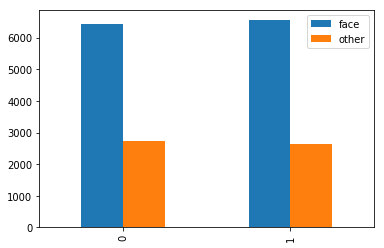

In [56]:
test = dict()
for i in range(len(labels)):
    test[i] = Counter(labels[i])
df = pandas.DataFrame.from_dict(test, orient='index')
df.plot(kind='bar')

In [57]:
print("******************************************")
print("******* Description of the datasets ****** ")
print("******************************************")

for i in range(len(labels)):
    faces = df['face'][i]
    others = df['other'][i]
    print("*************** DATASET N° {0:1} ************* ".format(i))
    print("------------------------------------------")
    print(" Number of faces : ",faces)
    print(" Number of others: ",others)
    print(" Total           : ", faces+others)
    print("------------------------------------------")
    print(" Number of faces :  {0:.0%}".format(faces/(faces+others)))
    print(" Number of others:  {0:.0%}".format(others/(faces+others)))
    print("******************************************")


******************************************
******* Description of the datasets ****** 
******************************************
*************** DATASET N° 0 ************* 
------------------------------------------
 Number of faces :  6439
 Number of others:  2733
 Total           :  9172
------------------------------------------
 Number of faces :  70%
 Number of others:  30%
******************************************
*************** DATASET N° 1 ************* 
------------------------------------------
 Number of faces :  6548
 Number of others:  2624
 Total           :  9172
------------------------------------------
 Number of faces :  71%
 Number of others:  29%
******************************************


* __Visualizing the Loss and the Early Stopping Checkpoint__

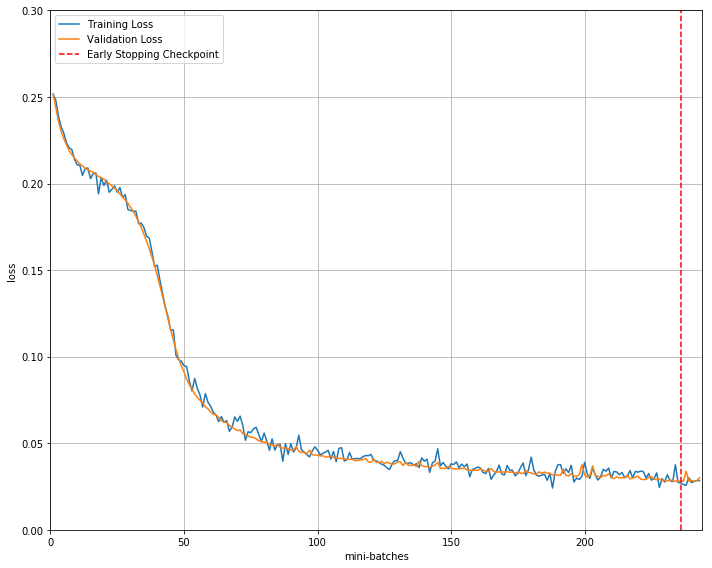

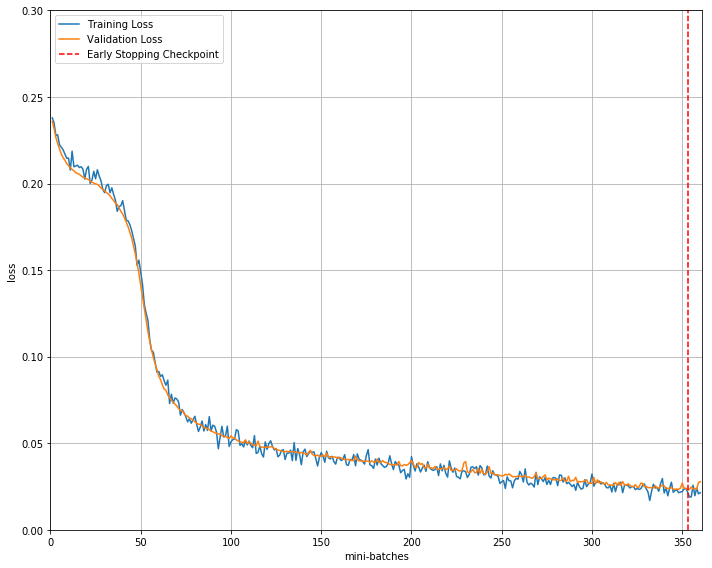

In [58]:
for i in range(len(labels)):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss[i])+1),train_loss[i], label='Training Loss')
    plt.plot(range(1,len(valid_loss[i])+1),valid_loss[i],label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss[i].index(min(valid_loss[i]))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('mini-batches')
    plt.ylabel('loss')
    plt.ylim(0, 0.3) # consistent scale
    plt.xlim(0, len(train_loss[i])+1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

## Step 5:

* __Some stats about the test dataset:__

In [59]:
def stat_img_test (test_loader):
    list_labels=[]
    for i, data in enumerate(test_loader,0):
        inputs, labels = data
        for j in range(len(labels)):
            list_labels.append(classes[labels[j]])
    
    return list_labels

In [60]:
labels = stat_img_test (test_loader)

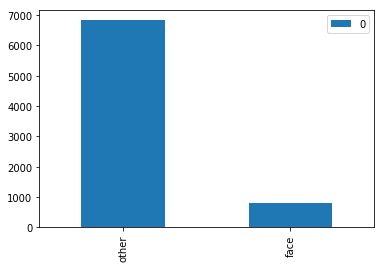

In [61]:
labels_counts = Counter(labels)
df = pandas.DataFrame.from_dict(labels_counts, orient='index')
df.plot(kind='bar')

In [62]:
faces = df[0]['face']
others = df[0]['other']

print("****** Description of the dataset ******* ")
print("-----------------------------------------")
print(" Number of faces : ",faces)
print(" Number of others: ",others)
print(" Total           : ", faces+others)
print("-----------------------------------------")
print(" Number of faces :  {0:.0%}".format(faces/(faces+others)))
print(" Number of others:  {0:.0%}".format(others/(faces+others)))
print("-----------------------------------------")


****** Description of the dataset ******* 
-----------------------------------------
 Number of faces :  797
 Number of others:  6831
 Total           :  7628
-----------------------------------------
 Number of faces :  10%
 Number of others:  90%
-----------------------------------------


* __Visualizing some random images from the validation dataset and comparing with the prediction  :__

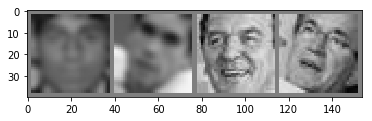

GroundTruth:   face  face  face  face
Predicted:   face  face  face  face


In [18]:
dataiter = iter(validation_loader[0])
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid([images[j] for j in range(4)]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
PATH = './models/model.pt'
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [19]:
correct = 0
total = 0
with torch.no_grad():
    avg = []
    for i in range(num_folds):
        for data in iter(validation_loader[i]):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if total > 10000 :
                print('Accuracy of the network on the %2d test images: %d %%'  % (total, 100 * correct / total))
                tmp = float(100 * correct / total)
                avg.append(tmp)
                break
    
    print('Average accuracy of the network : {} %'.format(int(np.average(avg))))


Accuracy of the network on the 10004 test images: 99 %
Average accuracy of the network : 99 %


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in iter(validation_loader[0]):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [21]:
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of other : 100 %
Accuracy of  face : 100 %


* __Visualizing some random images from the test dataset and comparing with the prediction  :__

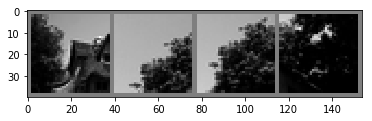

GroundTruth:  other other other other
Predicted:  other other other other


In [22]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for data in iter(test_loader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %2d test images: %d %%'  % (total,
    100 * correct / total))

Accuracy of the network on the 7628 test images: 98 %


In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in iter(test_loader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [25]:
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of other : 99 %
Accuracy of  face : 87 %


In [26]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [34]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(testset, batch_size=10000)
    train_preds = get_all_preds(net, test_loader)

In [37]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[6813   18]
 [ 103  694]]


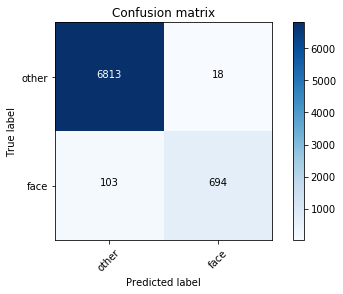

In [40]:
cm = confusion_matrix(testset.targets, train_preds.argmax(dim=1))
plot_confusion_matrix(cm, classes)